# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
Есть несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# План работы

- Импорт библиотек и загрузка данных (в процессе работы, может выявится необходимсть добавить еще какие-то библиотеки), первичное ознакомление с данными;
- Предобработка, более детальный осмотр данных на наличие пропусков, странных значений, дубликатов;
- Исследовательский анализ данных, осмотр характера распределения данных;
- Решить 1 задачу, создав пайплайн для нахождения лучшей модели для предсказания уровня удовлетворенности рабочим процессом;
- Решить 2 задачу, проведя дополнительные исследования по части ИАД (портрет типичного увольняющегося и проверка связи между признаками "удовлетворенность работой" и "вероятность увольнения"), а также составить пайплайн для нахождения лучшей модели для предсказания;
Написать общие выводы и рекомендации заказчикку по итогам проделанной работы.

## Импорт библиотек

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import math
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42


import warnings

warnings.filterwarnings("ignore")


## Задача №1

### Считывание данных

In [5]:
try:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except (FileNotFoundError, OSError) as e:
    try:
        train = pd.read_csv(r'C:\Users\YourUsername\Documents\project\train_job_satisfaction_rate.csv')
        X_test = pd.read_csv(r'C:\Users\YourUsername\Documents\project\test_features.csv')
        y_test = pd.read_csv(r'C:\Users\YourUsername\Documents\project\test_target_job_satisfaction_rate.csv')
    except (FileNotFoundError, OSError):
        print("Ошибка: не удалось загрузить данные")
else:
    print("Данные успешно загружены")

Данные успешно загружены


In [6]:
#Функция для ознакомления
for name, df in [('train', train), ('X_test', X_test), ('y_test', y_test)]:
    print()
    print(f"Выводим инфо о дф {name}:")
    df.info()
    print()
    print(f"Выводим 3 строки дф {name}:")
    display(df.head(3))


Выводим инфо о дф train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Выводим 3 строки дф train:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11



Выводим инфо о дф X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Выводим 3 строки дф X_test:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200



Выводим инфо о дф y_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

Выводим 3 строки дф y_test:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


Вывод по импорту библиотек и загрузке данных.
Мы загрузили все необходимые и потенциально нужные библиотеки. При первичном осмотре можно сказать, что данные загрузились корректно. Перейдем к обработке данных.

### Предобработка данных

Осмотрим каждый дф на наличие пропусков, выбросов и странных значений. Напишем для этого функцию:

In [7]:
def get_info(df):
    print('Количество дубликатов:', df.duplicated().sum())
    display(df.head())
    print()
    display(df.info())
    print()
    display(df.describe())
    # Посмотрим на уникальные значения в столбцах со строковыми значениями:
    string_columns = df.select_dtypes(include=['object']).columns
    for col in string_columns:
        unique_values = df[col].unique()
        print(f"\nUnique values for column '{col}':")
        for val in unique_values:
            print(val)

In [8]:
get_info(train)

Количество дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Unique values for column 'dept':
sales
hr
technology
purchasing
marketing
nan

Unique values for column 'level':
junior
middle
sinior
nan

Unique values for column 'workload':
medium
high
low

Unique values for column 'last_year_promo':
no
yes

Unique values for column 'last_year_violations':
no
yes


In [9]:
get_info(X_test)

Количество дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Unique values for column 'dept':
marketing
hr
sales
purchasing
technology
nan
 

Unique values for column 'level':
junior
middle
sinior
nan

Unique values for column 'workload':
medium
low
high
 

Unique values for column 'last_year_promo':
no
yes

Unique values for column 'last_year_violations':
no
yes


К концу проекта заметил, что есть значения ' ', а не только nan. Меняем их на nan:

In [10]:
X_test.loc[X_test['dept'] == ' ', 'dept'] = np.nan
X_test.loc[X_test['workload'] == ' ', 'workload'] = np.nan

In [11]:
X_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [12]:
X_test['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [13]:
get_info(y_test)

Количество дубликатов: 0


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


В данных есть пропуски, в двух датафреймах (train, X_test) в двух столбцах (debt и level). Их по заданию, насколько я понял следует обработать далее через пайплайн.
В остальном все данные загружены корректно, странных значений пока не видно, возможно, они проявятся на этапе ИАД. Думаю, что можно переходить к нему. 

### Исследовательский анализ данных

Напишем функции для анализа данных. Одну для количественных признаков, другую для категориальных. (В данном случае эти функции я возьму из предыдущего своего проекта.)

In [14]:
def plot_num_columns(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = numeric_columns[numeric_columns != 'id']
    for col in numeric_columns:
        f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                             figsize=(15, 5), 
                                             sharex=True,
                                             gridspec_kw=dict(height_ratios=[4,1]))
        sns.histplot(data=df, x=col, kde=True, ax=axs_hist, color='lightgreen', edgecolor='green')\
            .set(title=f'Гистограмма распределения {col}',
                 ylabel='Количество записей')
        sns.boxplot(data=df, x=col, ax=axs_box, color='lightgreen')\
            .set(xlabel=f'{col}');

In [15]:
def plot_cat_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    num_plots = len(categorical_cols)
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 5 * num_plots))

    if num_plots == 1:
        sns.countplot(x=categorical_cols[0], data=df, ax=axes, palette="Set1")
        axes.set_title(f'График {categorical_cols[0]}')
        axes.set_xlabel(categorical_cols[0])
    else:
        for i, col in enumerate(categorical_cols):
            sns.countplot(x=col, data=df, ax=axes[i], palette="Set1")
            axes[i].set_title(f'График {col}')
            axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

#### df train

In [16]:
train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


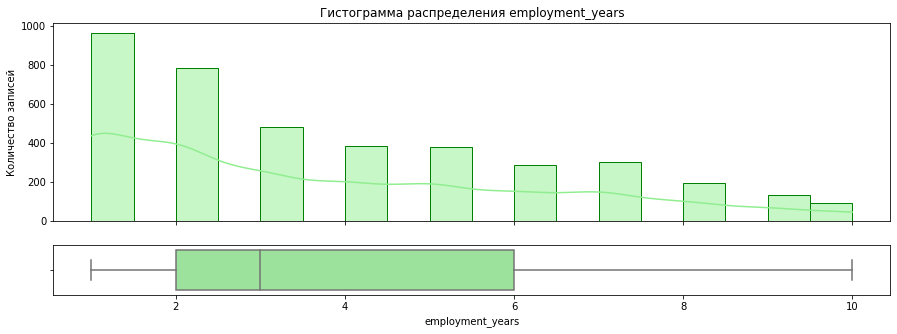

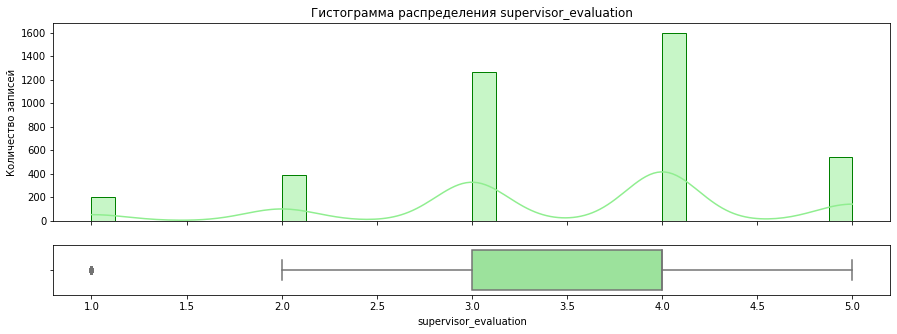

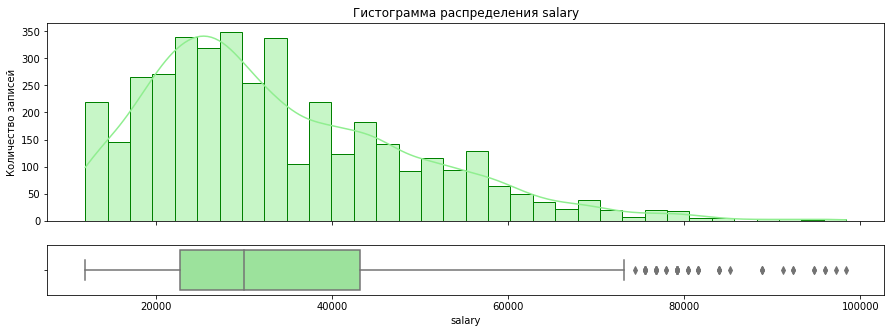

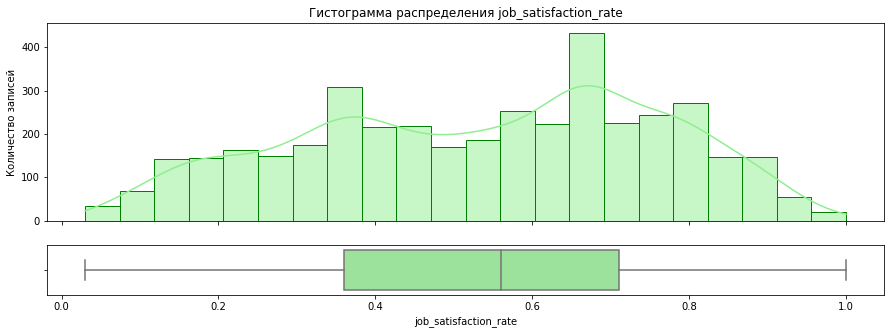

In [17]:
plot_num_columns(train)

Вывод по количественным признакам:
 - Средний стаж работы сотрудников в компании составляет 3-4 года;
 - Работают в основном люди удовлетворительно и хорошо(4 и 5),  но есть и "индивиды" с наихудшими оценками, а также отличники труда;
 - Средний заработок - 30000, при этом нормальными значениями можно считать показатели до 75000 (исходя из боксплота). Выбросов немало, но это скорее всего руководящий состав, их зарплаты не пересекают отметку 100000;
 - Средний уровень удовлетворенности работой 0,53-0,56.

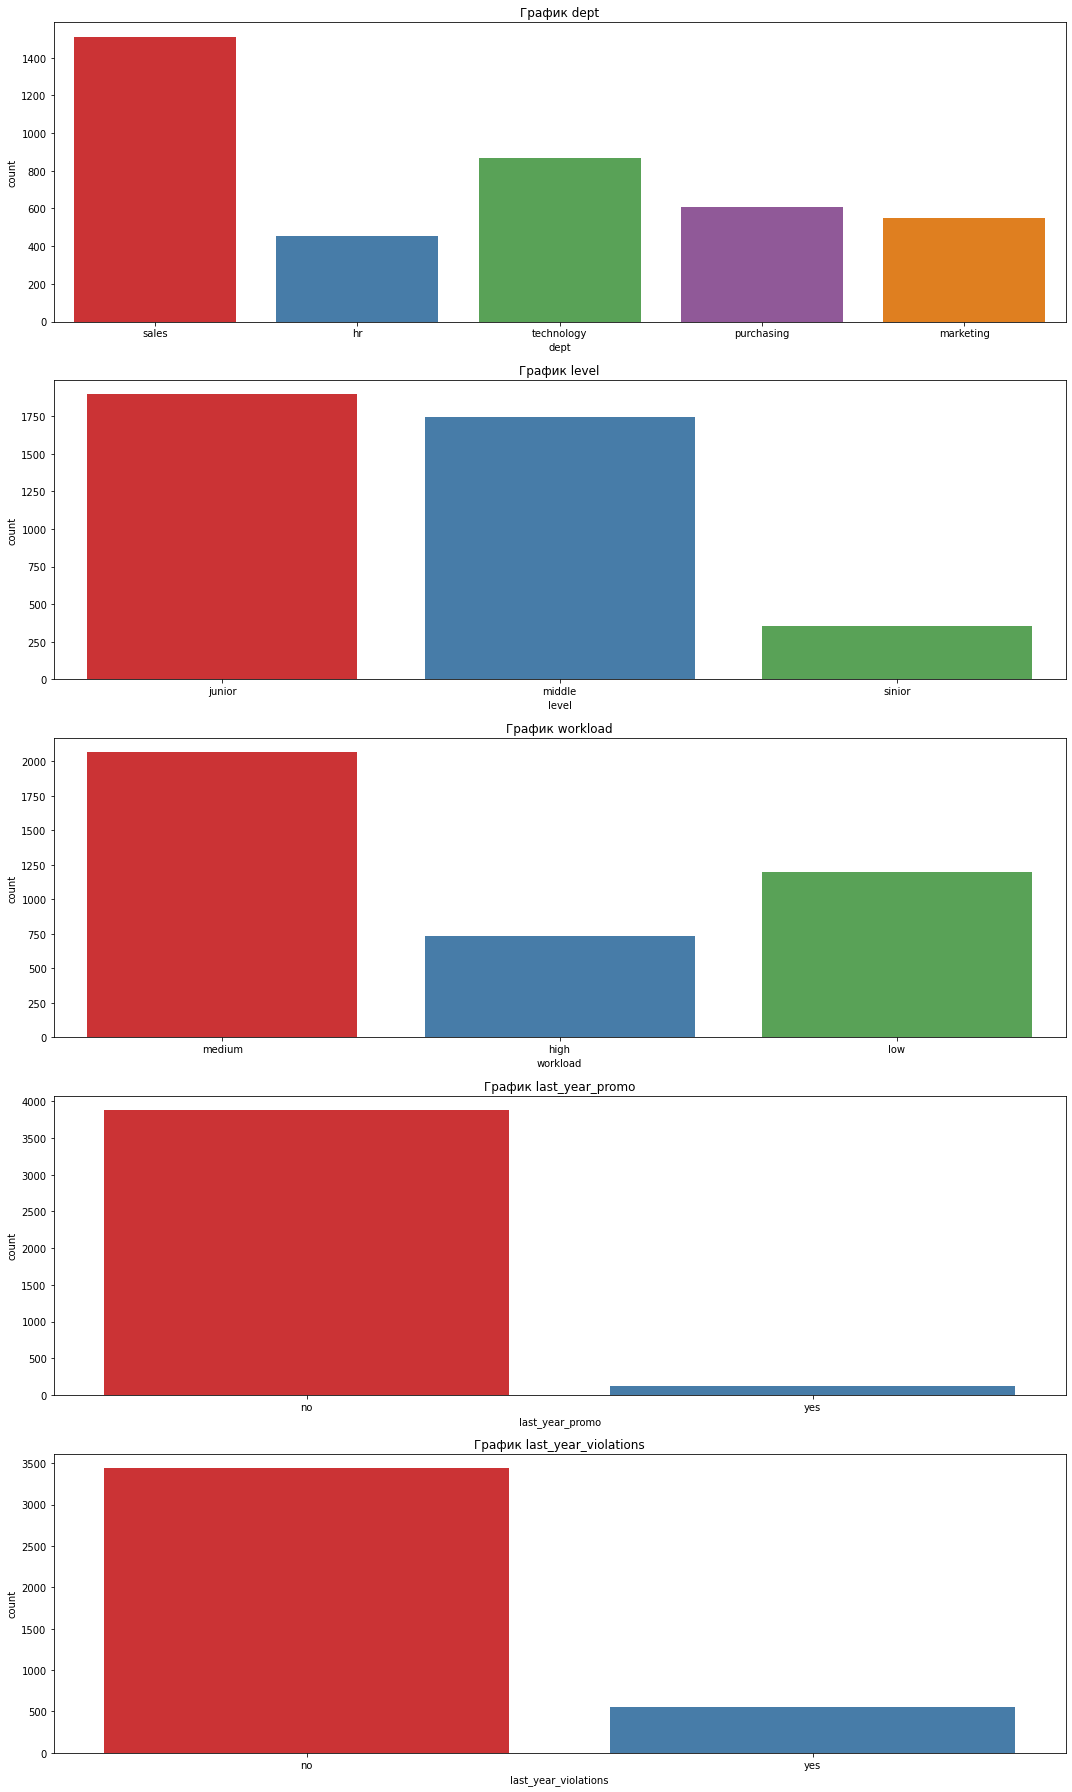

In [18]:
plot_cat_columns(train)

Вывод по категориальным признакам:
  - Больше всего народа заняты в продажах, остальные категории распределены более-менее равномерно;
  - Распределение категорий должностей ожидаемо. Джунов больше всего, с небольшим отсаванием идут мидлы, а вот опытных сотрудников совсем немного;
  - Больше всего работников имеют умеренную загрузку, следом идут люди с низкой, и совсем мало имеют высокую; 
  - Совсем небольшое количество сотрудников получали повышение в прошлом году;
  - Совсем небольшое количество сотрудников нарушали трудовой договор.

#### df X_test

In [19]:
X_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


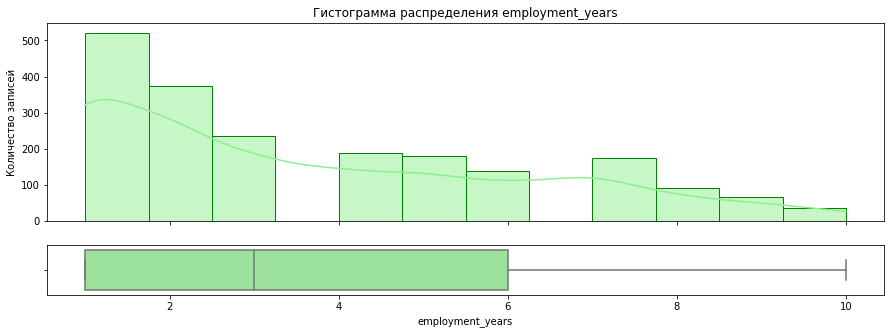

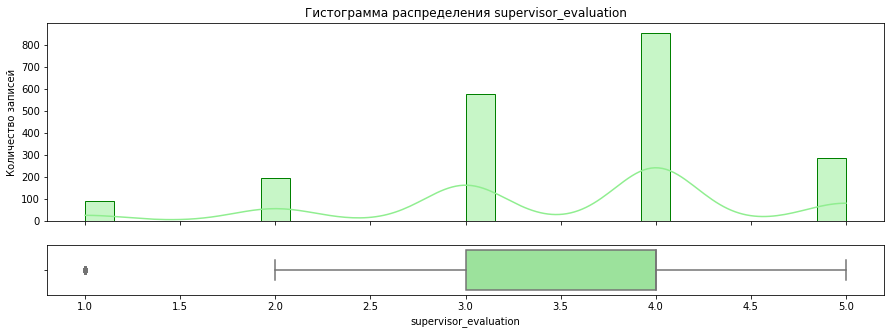

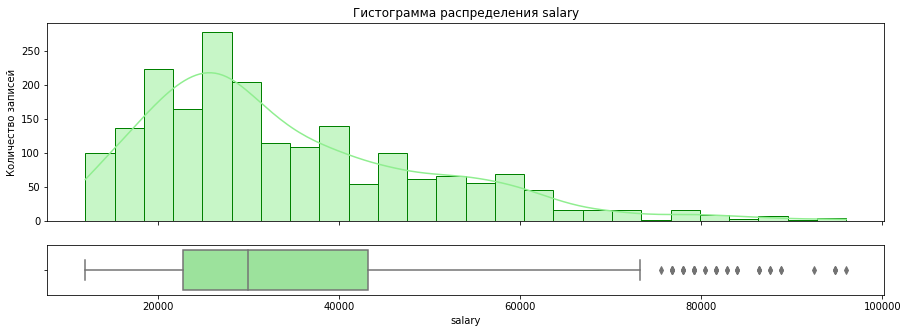

In [20]:
plot_num_columns(X_test)

Вывод по количественным признакам:
    Все количественные признаки распределены в целом аналогично тренировочной выборке.

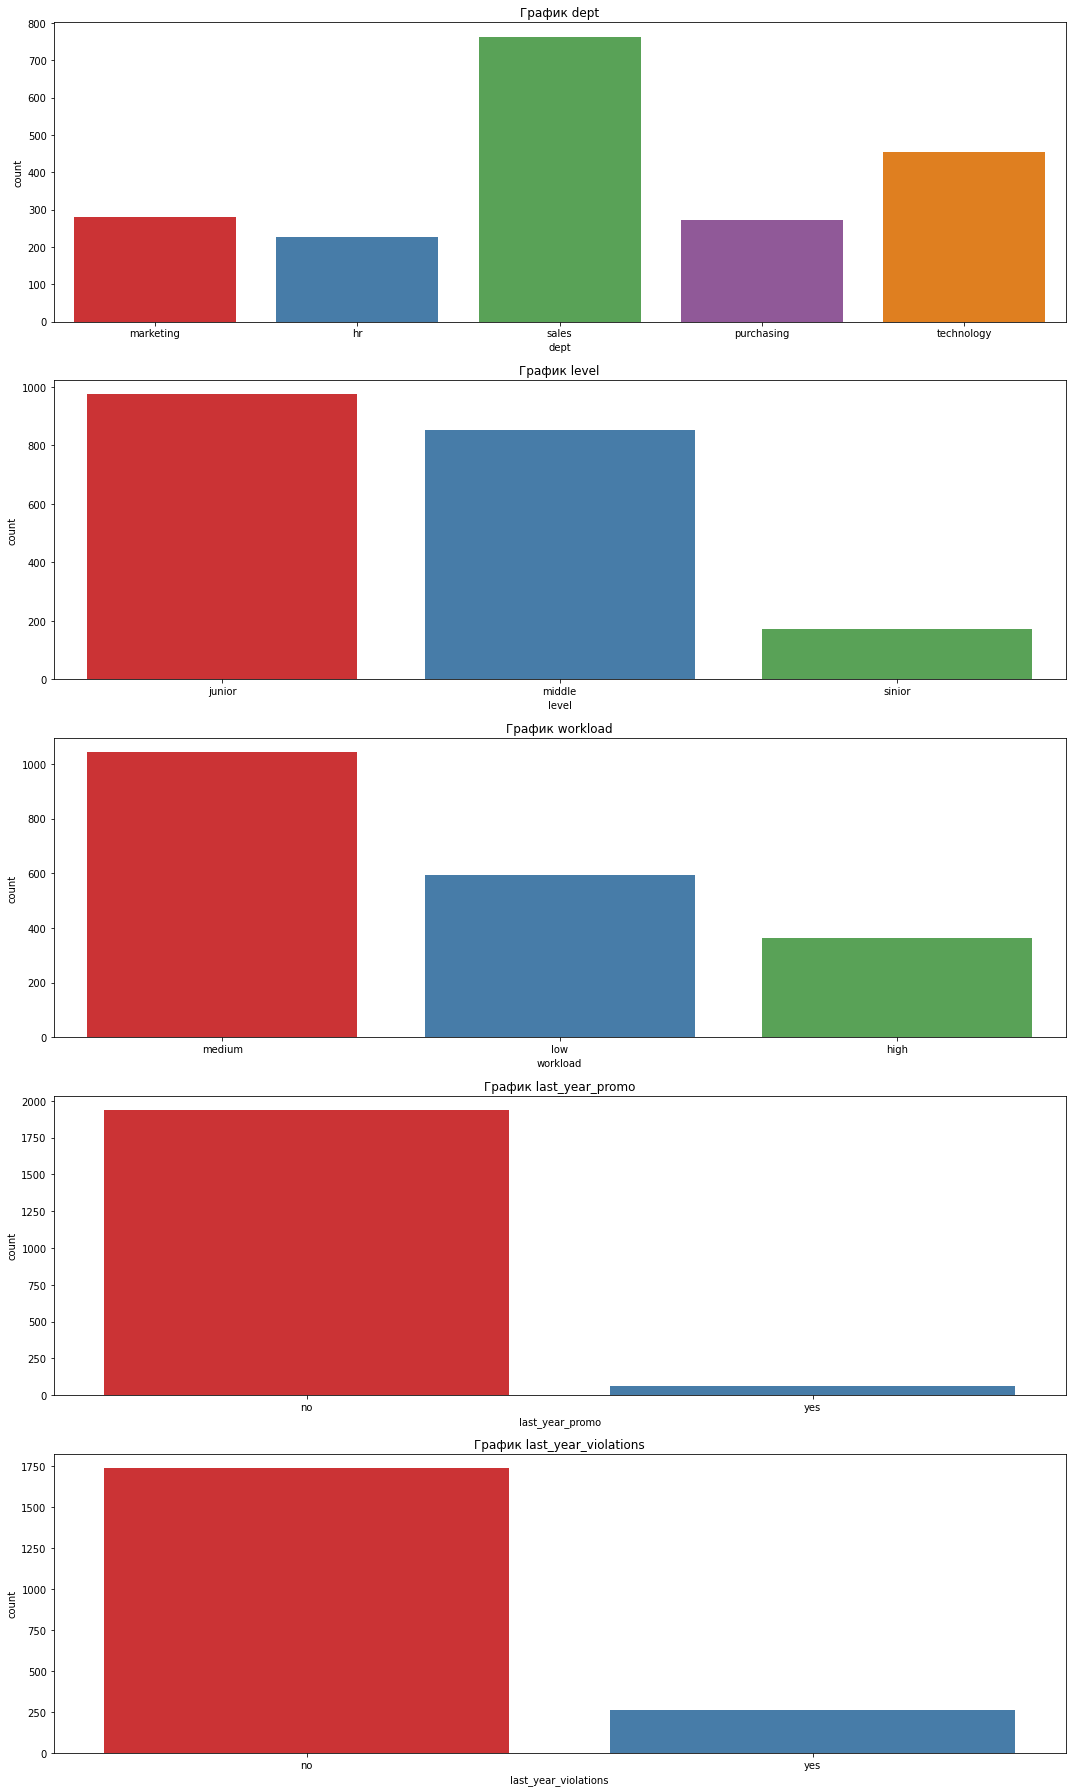

In [21]:
plot_cat_columns(X_test)

Вывод по категориальным признакам:
    Все категориальные признаки имеют схожее распредление с тренировочной выборкой.

#### df y_test

In [22]:
y_test.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


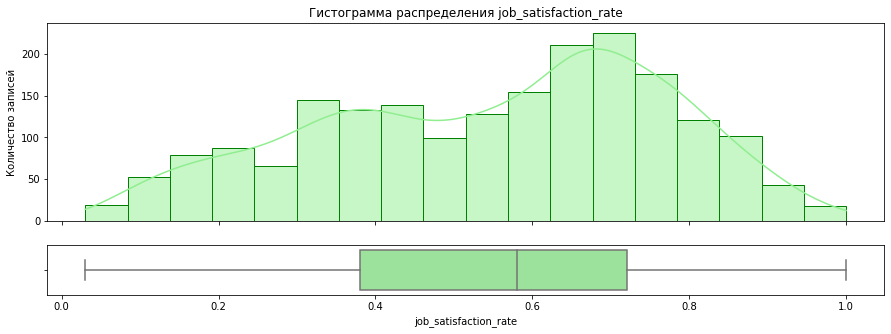

In [23]:
plot_num_columns(y_test)

Вывод по целевому признаку тествой выборки:
    В целом признак распределён практически одинакого с тренировочной выборкой.

#### Вывод по ИАД

Ни один из признаков не имеет нормального распределения, как в тренировочной так и в тестовой выборке. Распределение признаков в тренировочной выборке и в тестовой практически идентично. Выводы по количественным признакам:

  - Средний стаж работы сотрудников в компании составляет 3-4 года;
    Работают в основном люди удовлетворительно и хорошо(3 и 4), но есть и "индивиды" с наихудшими оценками, а также отличники труда;
  - Средний заработок - 30000, при этом нормальными значениями можно считать показатели до 75000 (исходя из боксплота). Выбросов немало, но это скорее всего руководящий состав, их зарплаты не пересекают отметку 100000;
    Средний уровень удовлетворенности работой 0,53-0,58.
  
Вывод по категориальным признакам:
  - Больше всего народа заняты в продажах, остальные категории распределены более-менее равномерно;
  - Распределение категорий должностей ожидаемо. Джунов больше всего, с небольшим отсаванием идут мидлы, а вот опытных сотрудников совсем немного;
  - Больше всего работников имеют умеренную загрузку, следом идут люди с низкой, и совсем мало имеют высокую;
  - Совсем небольшое количество сотрудников получали повышение в прошлом году;
  - Совсем небольшое количество сотрудников нарушали трудовой договор.

### Корреляционный анализ данных

In [24]:
train_1 = train.set_index('id')

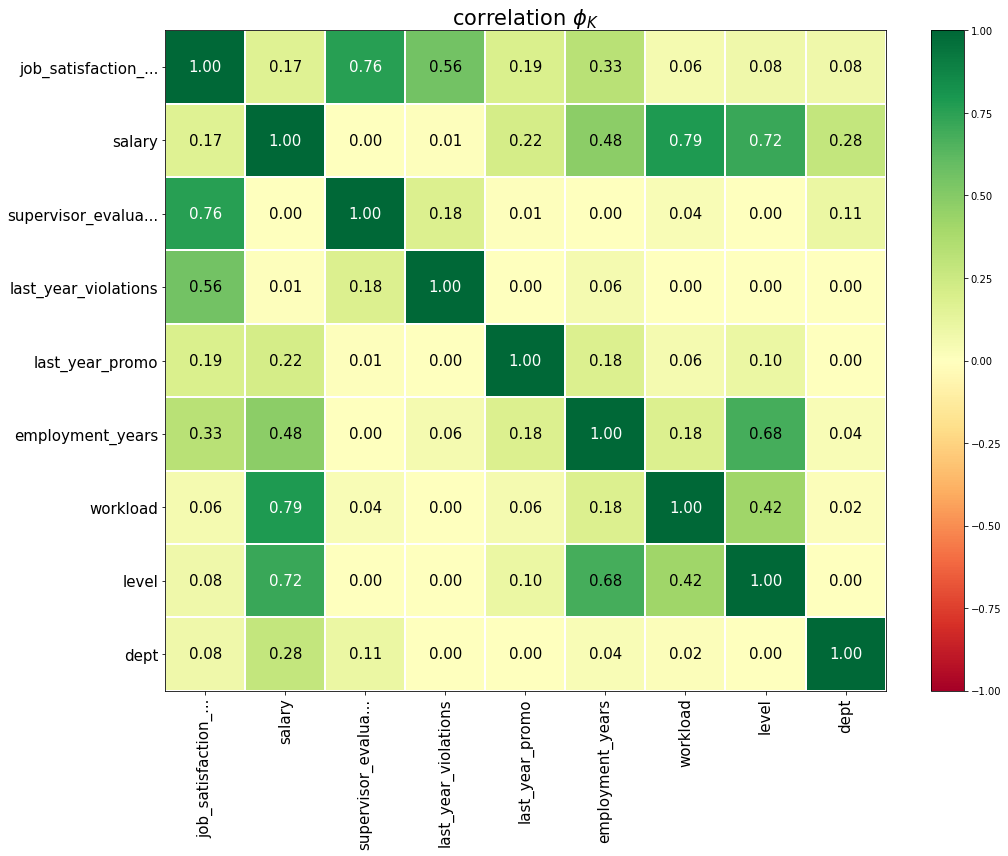

In [25]:
interval_cols = ['salary', 'job_satisfaction_rate']


train_1 = phik_matrix(train_1, interval_cols=interval_cols)

plot_correlation_matrix(
    train_1.values,
    x_labels=train_1.columns,
    y_labels=train_1.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Вывод по матрице корреляций:
    Сильный корреляций(>0,9), не обнаружено, отсюда следует, что мультиколлинеарность в данных отсутствует.

### Подготовка данных и  создание пайплайна

#### Подготовка данных

Нарушения трудового договора (last_year_violations), Повышение за последний год (last_year_promo), Отдел (dept) — кодируем с помощью OneHotEncoder.
Уровень должности (level) и Уровень загруженности (workload) — нужно кодировать с помощью OrdinalEncoder, это ранговые признаки.
В признаках, встречаются пропуски (Используем SimpleImputer)
Целевой признак — Удовлетворённость сотрудника работой в компании (job_satisfaction_rate).
Количественные признаки: Количество лет в компании (employment_years), Оценка работодателя (supervisor_evaluation) и Зарплата (salary) - масштабируем.

Небольшое пояснение перед пайплайном:
  - На этапе предобработки было выявлено, что в данных есть пропуски, нужно будет использовать SimpleImputer;
  - Все колиественные признаки кроме целевого будем масштабировать;
  - Признаки "было ли повышение" и "было ли нарушение" - бинарные - будем кодировать через OHE. Отдел хоть и не бинарный будем также кодировать через OHE;
  - Признаки "загруженность", "должность" - ранговые, к ним применим OrdinalEncoder.

In [26]:
train2 = train.drop(['id'], axis=1)

In [27]:
X_train = train2.drop(['job_satisfaction_rate'], axis=1)
y_train = train2['job_satisfaction_rate']
X_train.shape

(4000, 8)

In [28]:
df_test = X_test.merge(y_test, on='id') #Объединим датафреймы

In [29]:
X_testing = df_test.drop(['job_satisfaction_rate','id'], axis=1)
y_testing = df_test['job_satisfaction_rate']
X_testing.shape

(2000, 8)

#### Пайплайн

In [30]:
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 
ohe_columns = ['last_year_violations', 'last_year_promo','dept']
ord_columns = ['level','workload']

In [31]:
ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore')
            )
        ]
    ) 

In [32]:
ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )   

In [33]:
data_preprocessor = ColumnTransformer([
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)], 
        remainder='passthrough')

In [34]:
pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())])
    

In [35]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 14),
        'models__max_features': range(5, 14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()]
    }
    
]

In [36]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

In [37]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [38]:
smape_scorer = make_scorer(smape, greater_is_better=False)
randomized = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_iter=50,
    n_jobs=-1
)

randomized.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Через RandomizedSearch на тренировочной не всегда выдает меньше 15.Но по заданию вроде обязательно меньше 15 только на тестовой. Gridsearch долго работает слишком, но он стабильно выдает меньше 15. Optuna не стал использовать, там немного больше возни получается.

In [39]:
y_pred_test = randomized.best_estimator_.predict(X_testing)
smape_test = smape(y_testing, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 14.484174578168046


In [40]:
results = pd.DataFrame(randomized.cv_results_)
results.mean_test_score = results.mean_test_score * -1
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028663,0.003015,0.009647,0.000593,passthrough,9,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-15.556416,-15.253767,-15.287981,-15.693817,-14.941669,15.346730,0.261000,6
1,0.028158,0.002691,0.010853,0.001217,RobustScaler(),9,5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",-20.454613,-20.296625,-20.481415,-20.365398,-19.525335,20.224677,0.355765,46
2,0.027217,0.001587,0.010666,0.000476,MinMaxScaler(),13,5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-19.646342,-19.602129,-19.973804,-19.917685,-19.210986,19.670189,0.271847,43
3,0.028603,0.001344,0.010943,0.000164,RobustScaler(),12,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",-17.810175,-16.689388,-17.551867,-17.871585,-17.004656,17.385534,0.463448,26
4,0.025017,0.001025,0.009305,0.000418,passthrough,11,8,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-17.352593,-16.093726,-16.777659,-16.991751,-16.606748,16.764495,0.417730,23
5,0.029395,0.002724,0.011699,0.002125,RobustScaler(),12,9,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",-16.307771,-15.865190,-16.360219,-16.817692,-15.710547,16.212284,0.392361,15
6,0.022185,0.000442,0.008967,0.000628,passthrough,9,5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-20.454613,-20.296625,-20.481415,-20.365398,-19.525335,20.224677,0.355765,46
7,0.024688,0.000554,0.009791,0.000491,StandardScaler(),6,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-20.533557,-20.784841,-19.300386,-20.372938,-19.385035,20.075351,0.613024,45
8,0.025724,0.001413,0.011093,0.001609,StandardScaler(),7,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-20.342595,-18.381364,-18.779250,-19.775794,-18.864336,19.228668,0.720114,40
9,0.027540,0.000459,0.011000,0.001024,StandardScaler(),9,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-19.793617,-18.472391,-19.310687,-19.359148,-18.065437,19.000256,0.633580,35


Исходя из данных видно, что чем больше глубина дерева и чем больше у него веток - тем выше точность и ниже метрика SMAPE. Вторая модель (линейная регрессия) проигрывает деревьям практически в сухую.

#### Анализ важности признаков модели

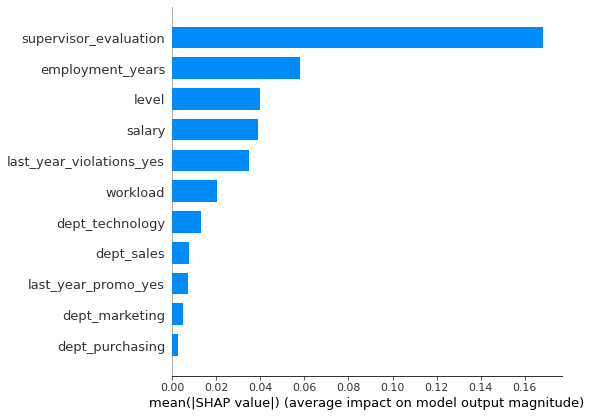

In [41]:
preprocessor = randomized.best_estimator_['preprocessor']
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = ord_columns
num_feature_names = num_columns
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])
best_model = randomized.best_estimator_.named_steps['models']

X_train_encoded = preprocessor.fit_transform(X_train)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_encoded)

shap.summary_plot(shap_values, X_train_encoded, feature_names=all_feature_names, plot_type='bar')



  0%|          | 0/100 [00:00<?, ?it/s]

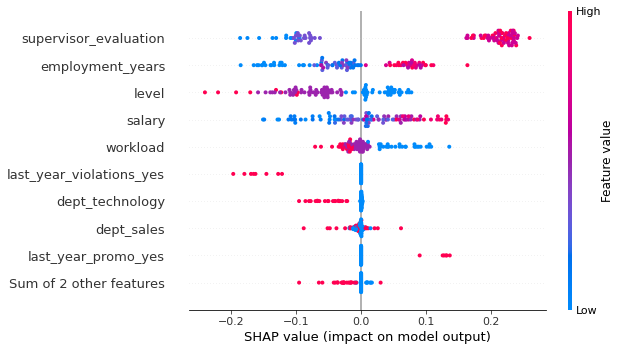

In [42]:
preprocessor = randomized.best_estimator_['preprocessor']
X_train_encoded = preprocessor.fit_transform(X_train)
model = randomized.best_estimator_.named_steps['models']

# Семплируем
sample_size = 100
x_test_shap = preprocessor.transform(X_test)
x_test_shap_sampled = x_test_shap[np.random.choice(x_test_shap.shape[0], size=sample_size, replace=False), :]

X_shap = shap.kmeans(X_train_encoded, 19)
explainer = shap.KernelExplainer(model.predict, X_shap, feature_names=all_feature_names)

shap_values = explainer.shap_values(x_test_shap_sampled)

# Создаем объект
explanation = shap.Explanation(values=shap_values, data=x_test_shap_sampled, feature_names=all_feature_names)

# Строим график
shap.plots.beeswarm(explanation)

Из выше построенных графиков видно, что у модели есть признак, на который она ориентируется в первую очередь - это оценка руководителя. Далее идут с большим отставанием стаж работы. Далее идут практически с одинаковым влиянием на предсказание - зарплата, должность и наличие нарушений договора. На остальные признаки модель практически не смотрит.

### Вывод по первой части

В рамках работы над первой задачей были загружены датафреймы, проведена минимально необходимая предобработка данных, сделан исследовательский и корреляционный анализ данных. Большинство признаков не имеют нормального распределения. Некоторые данные имеют сильный дисбаланс классов (повышения, нарушения). Более подробные особенности распределения данных приведены в главе ИАД. Корреляционный анализ показал отсутствие мультиколлинеарности в признаках. Далее  был создан пайплайн для подготовки данных и нахождения лучшей модели из двух предложенных. Методом RandomizedSearch, было установлено, что лучшая модель из двух предложенных - это дерево решений с максимальной глубиной равной 13 и количеством признаков равным 8. Метрика SMAPE на тестовой выборке составила 14,65 - что удовлетворяет условиям задачи. Модель decisionthree более гибкая модель с более высокими адаптивными возможностями чем линейная регрессия. Думаю что поэтому, она справилась заметно лучше.

## Задача №2

### Загрузка и осмотр данных

In [43]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    X_test2 = pd.read_csv('/datasets/test_features.csv')
    y_test2 = pd.read_csv('/datasets/test_target_quit.csv')
except (FileNotFoundError, OSError) as e:
    try:
        train_quit = pd.read_csv(r'C:\Users\YourUsername\Documents\project\train_quit.csv')
        X_test2 = pd.read_csv(r'C:\Users\YourUsername\Documents\project\test_features.csv')
        y_test2 = pd.read_csv(r'C:\Users\YourUsername\Documents\project\test_target_quit.csv')
    except (FileNotFoundError, OSError):
        print("Ошибка: не удалось загрузить данные")
else:
    print("Данные успешно загружены")

Данные успешно загружены


In [44]:
#Функция для ознакомления
for name, df in [('train_quit', train_quit), ('X_test2', X_test2), ('y_test2', y_test2)]:
    print()
    print(f"Выводим инфо о дф {name}:")
    df.info()
    print()
    print(f"Выводим 3 строки дф {name}:")
    display(df.head(3))


Выводим инфо о дф train_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Выводим 3 строки дф train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no



Выводим инфо о дф X_test2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Выводим 3 строки дф X_test2:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200



Выводим инфо о дф y_test2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Выводим 3 строки дф y_test2:


,id,quit
0,999029,yes
1,372846,no
2,726767,no


Вывод по загрузке:
    Все данные загрузились корректно. Перейдем к предобработке.

### Предобработка данных

#### df train_quit

In [45]:
get_info(train_quit)

Количество дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



Unique values for column 'dept':
sales
purchasing
marketing
technology
hr

Unique values for column 'level':
middle
junior
sinior

Unique values for column 'workload':
high
medium
low

Unique values for column 'last_year_promo':
no
yes

Unique values for column 'last_year_violations':
no
yes

Unique values for column 'quit':
no
yes


Похоже, что этот дф обрабатывать не нужно. Перейдем к следующему.

#### df X_test

In [46]:
get_info(X_test2)

Количество дубликатов: 0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Unique values for column 'dept':
marketing
hr
sales
purchasing
technology
nan
 

Unique values for column 'level':
junior
middle
sinior
nan

Unique values for column 'workload':
medium
low
high
 

Unique values for column 'last_year_promo':
no
yes

Unique values for column 'last_year_violations':
no
yes


In [47]:
X_test2.loc[X_test2['dept'] == ' ', 'dept'] = np.nan
X_test2.loc[X_test2['workload'] == ' ', 'workload'] = np.nan

Тут как и в первой задаче имеются единичные пропуски (столбцы level и dept). По заданию, мы должны будем их обработать в пайплайне. Так что пока оставим их как есть. В остальном, данные также выглядят корректно. Идем дальше.

#### df y_test

In [48]:
get_info(y_test2)

Количество дубликатов: 0


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



Unique values for column 'quit':
yes
no


Снова всё корректно. Перейдем к ИАД.

### Исследовательский анализ данных

#### df train_quit

In [49]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


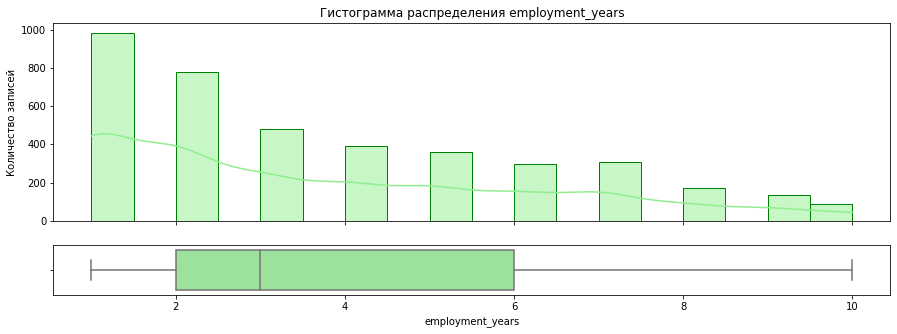

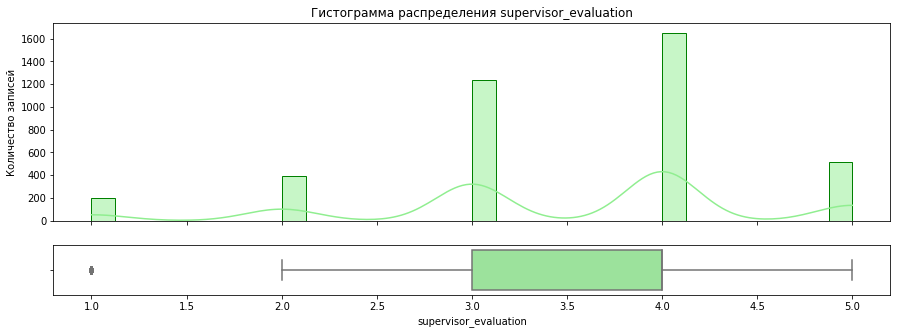

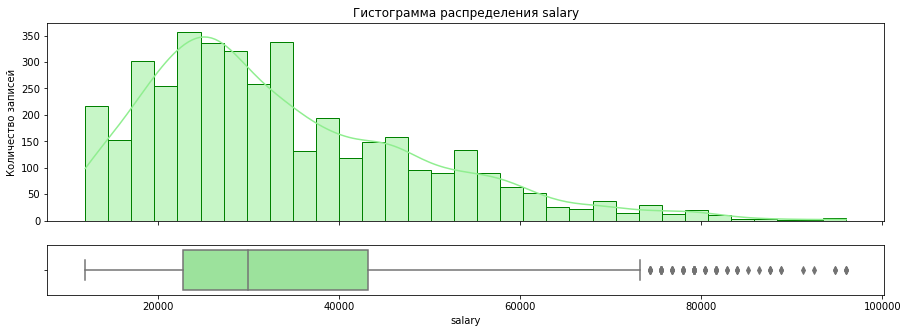

In [50]:
plot_num_columns(train_quit)

Вывод по количественным признакам: данные распределены идентично предыдущей задаче: 
  - нормального распределения среди них нет;
  - средний стаж 3-4 года;
  - средняя оценка руководителя 3,5 - 4 балла;
  - нормальные значения зарплат лежат в диапазоне 15000-75000.

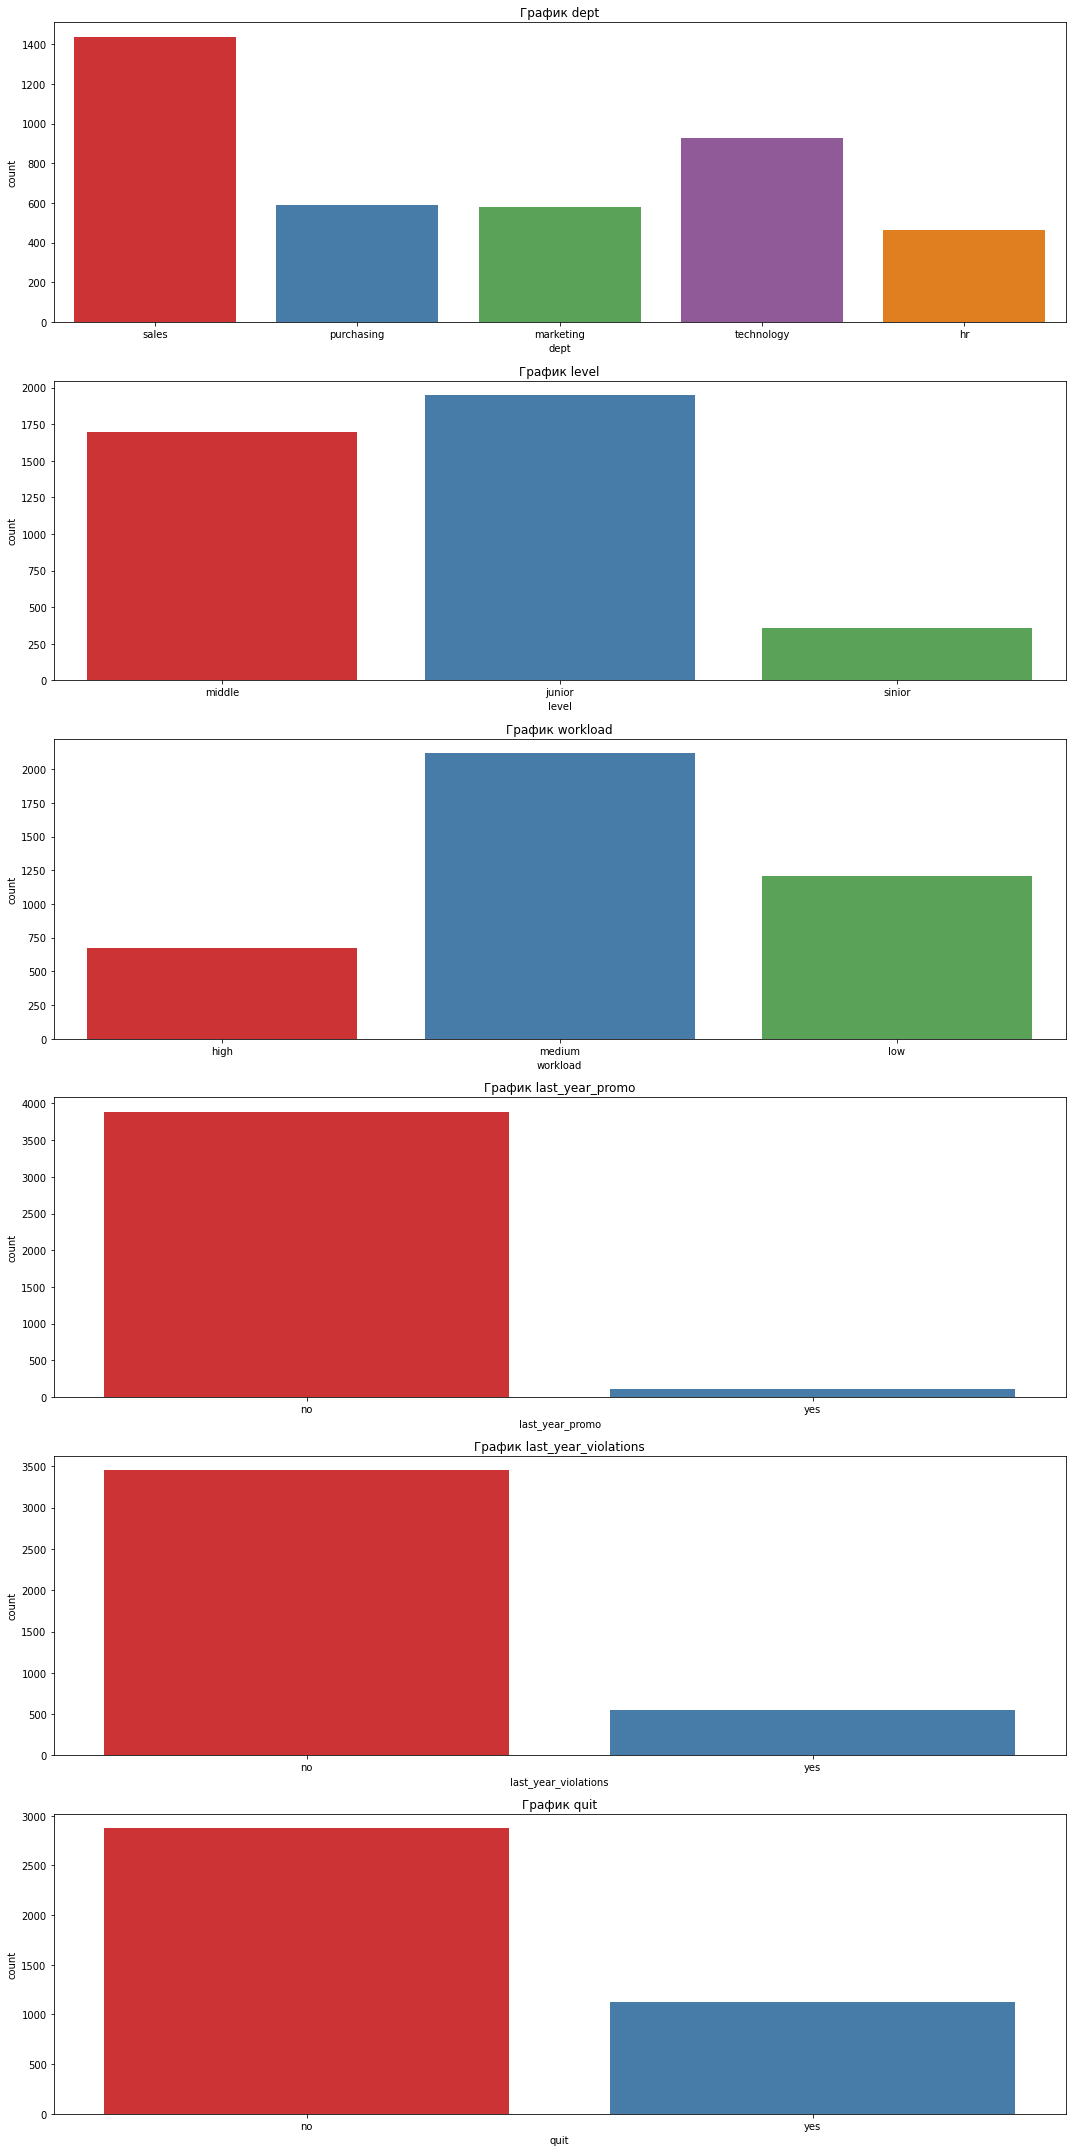

In [51]:
plot_cat_columns(train_quit)

Вывод по категориальным признакам:
    Все также очень похоже на первую задачу, больше всего сотрудников занято в продажах и технологиях, больше всего джунов и мидлов, нагрузка в основном средняя и небольшая, повышений и предупреждений крайне мало по сравнению с основной массой. Добавился новый целевой признак - quit. Уволившихся примерно в 2-3 раза меньше чем тех кто остался.

#### df X_test

In [52]:
X_test2.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


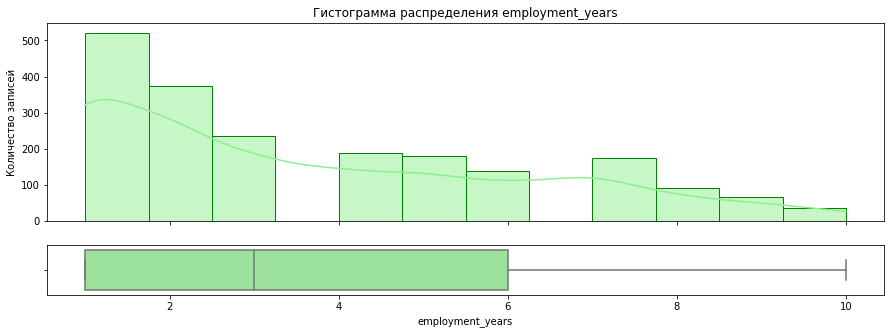

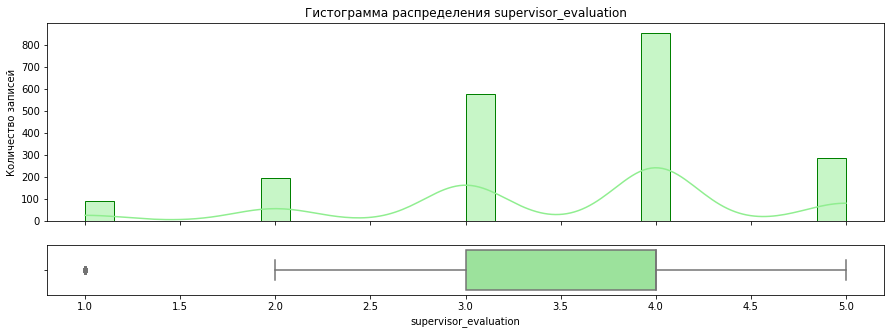

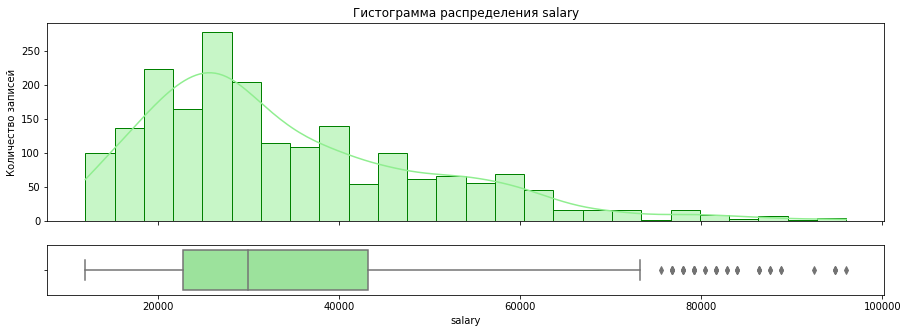

In [53]:
plot_num_columns(X_test)

вывод по количественным признакам:
Данные практически идентичны тренировочной выборке, небольшое исключение - стаж. Там по некоторым годам отсутсвуют значения, но среднее практически не поменялось.

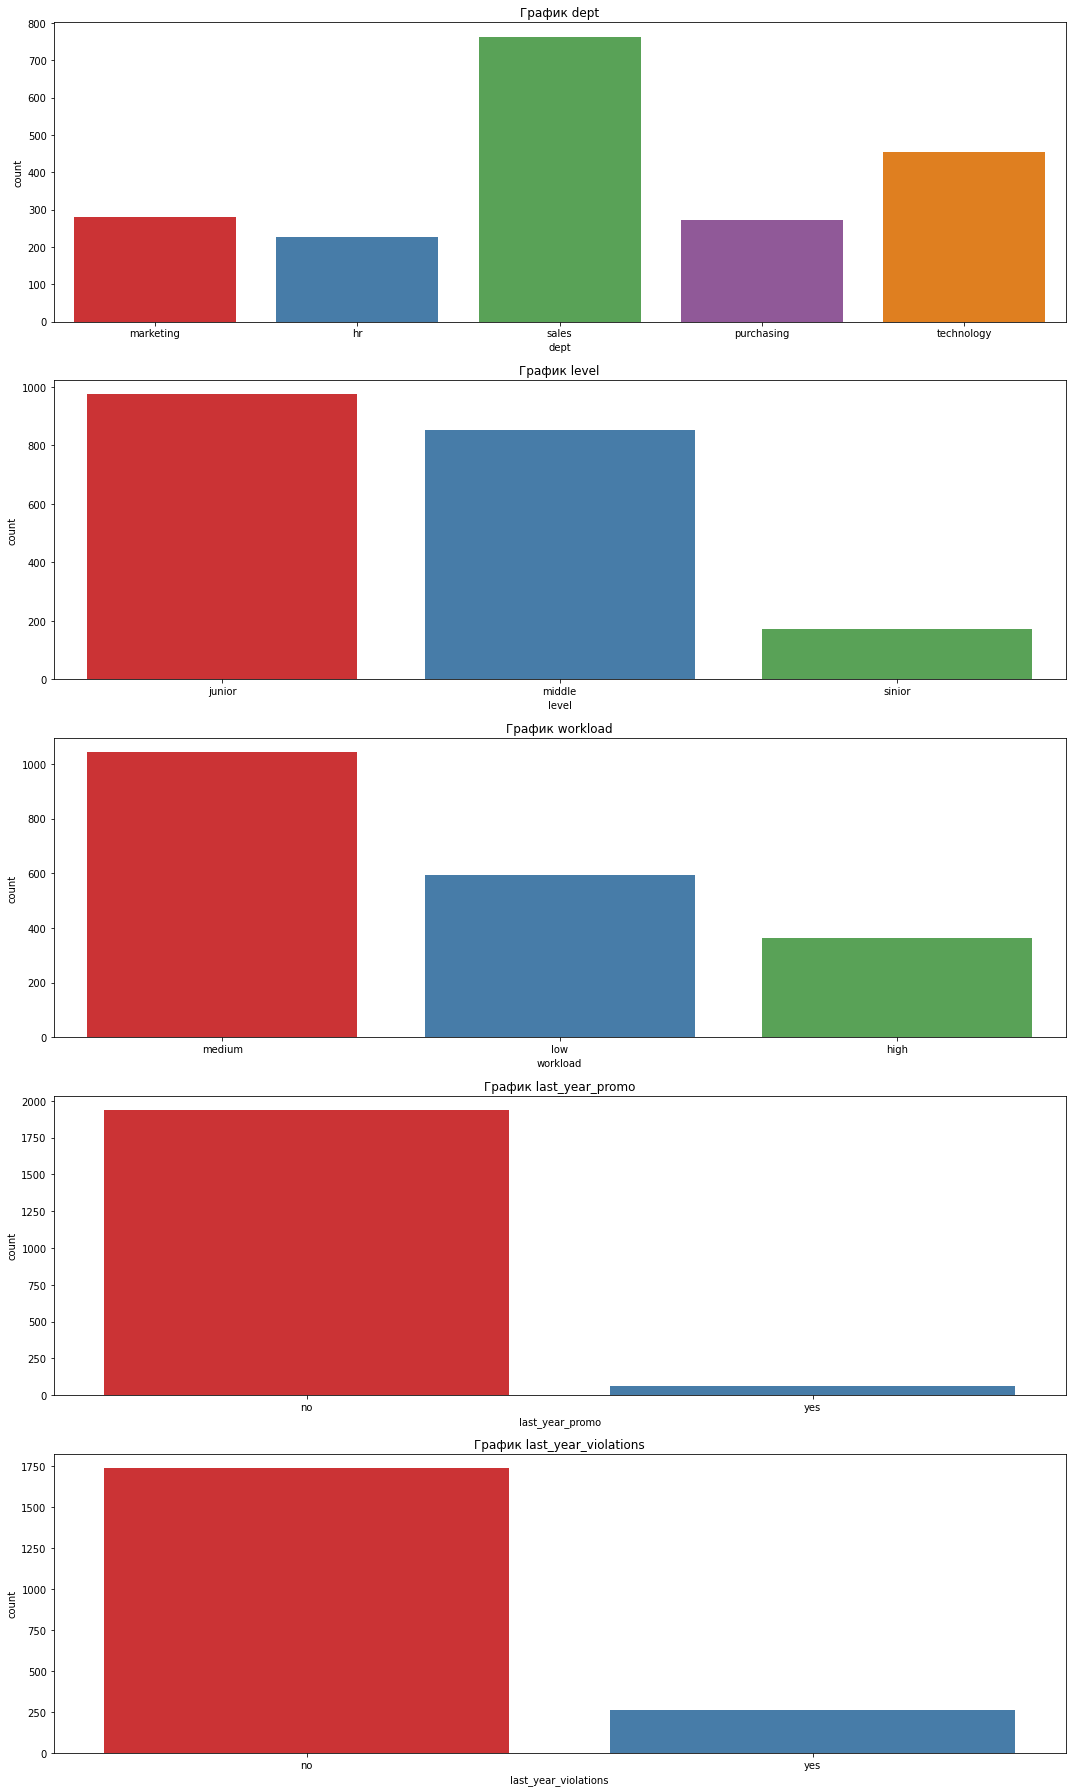

In [54]:
plot_cat_columns(X_test2)

Вывод по категориальным данным: практически полное совпадение с тренировочной выборкой.

#### df y_test

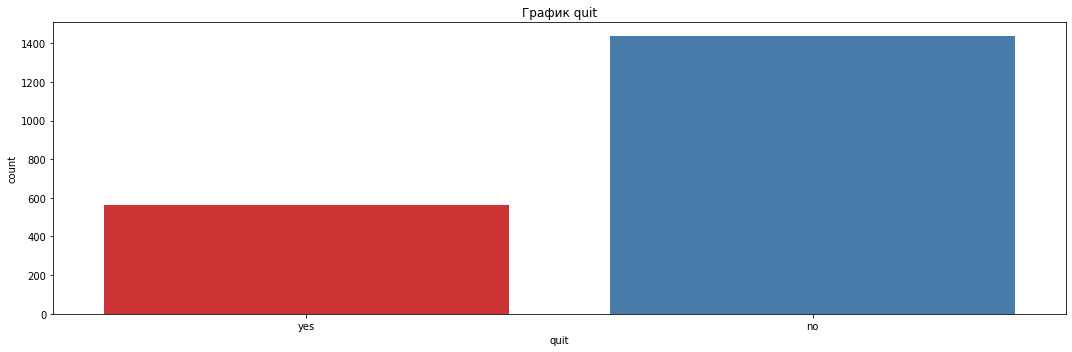

In [55]:
plot_cat_columns(y_test2)

Вывод по y_test2 - Всё-таки по большей части, люди остаются на работе, несмотря на большую текучку.

#### Портрет уволившегося сотрудника

Для того чтобы составить портрет уволившегося сотрудника надо посмотреть как распределен целевой признак в различных категориях. Начнем с количественных признаков.

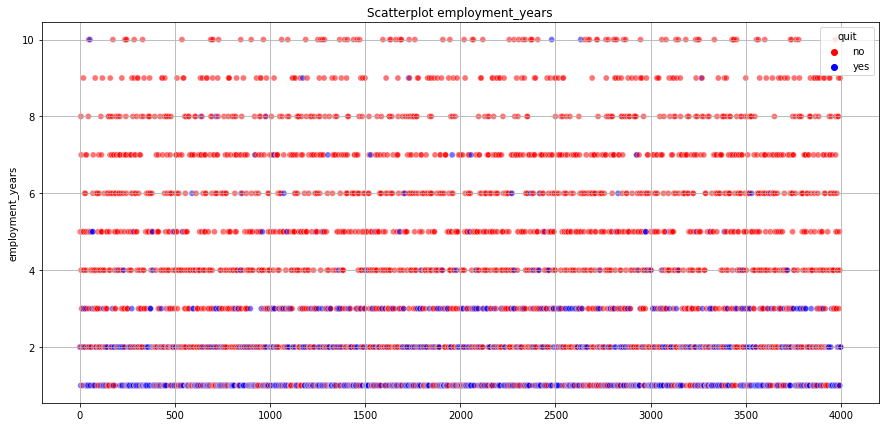

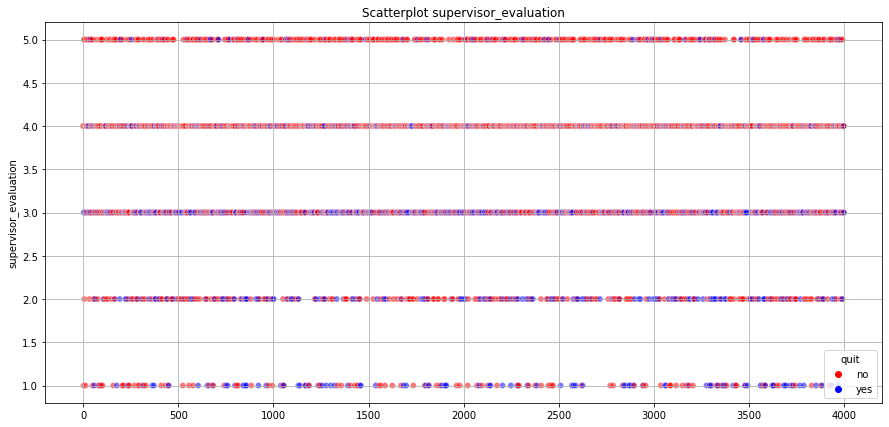

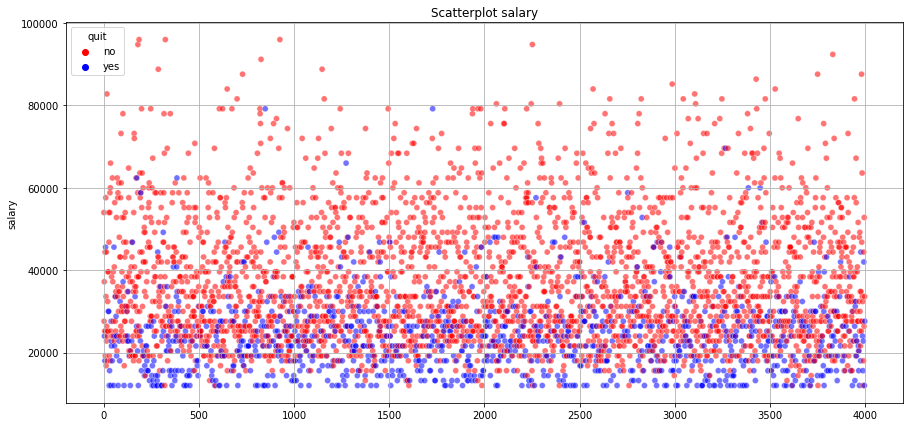

In [56]:
def scatterplot_with_hue(df, hue):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
    numerical_features = numerical_features.drop('id')

    # Создаем список цветов для каждого значения hue
    colors = ['red', 'blue']

    for i, feature in enumerate(numerical_features):
        plt.figure(figsize=(15, 7))
        sns.scatterplot(x=df.index, y=feature, hue=hue, palette=colors, data=df, alpha=0.55)
        plt.title(f"Scatterplot {feature}")
        plt.grid(True)
        plt.show()

scatterplot_with_hue(train_quit, 'quit')

Вывод по количественным признакам для составления портрета:

    - Стаж работы влияет на вероятность увольнения. В основном люди увольняются не проработав 3-4 лет. Видимо за этот срок приходит осознание заинтересованности в выбранной профессии и срастание с коллективом и начальством или же наоборот, отторжение;
    - Оценка работы сотрудника со стороны руководителя также влияет на веротяность увольнения. Сотрудники с оценка 3 и ниже как правило увольняются чаще тех, кого балуют 4 и 5;
    - С зарплатой тоже всё предельно ясно, ниже 30000 никто зарабатывать не хочет, и скорее всего по прошествии некоторого периода без повышения - увольняется.
    Перейдем к категориальным признакам.

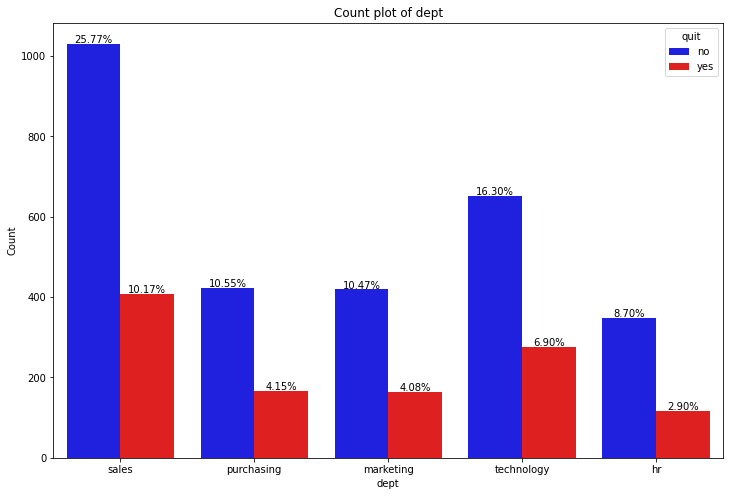

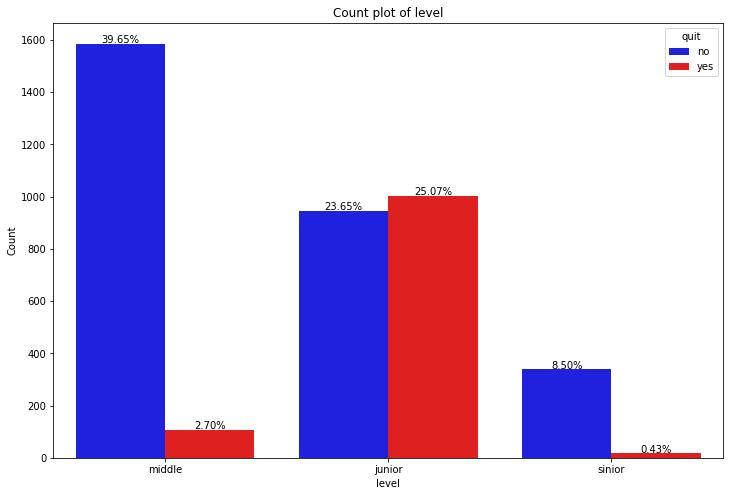

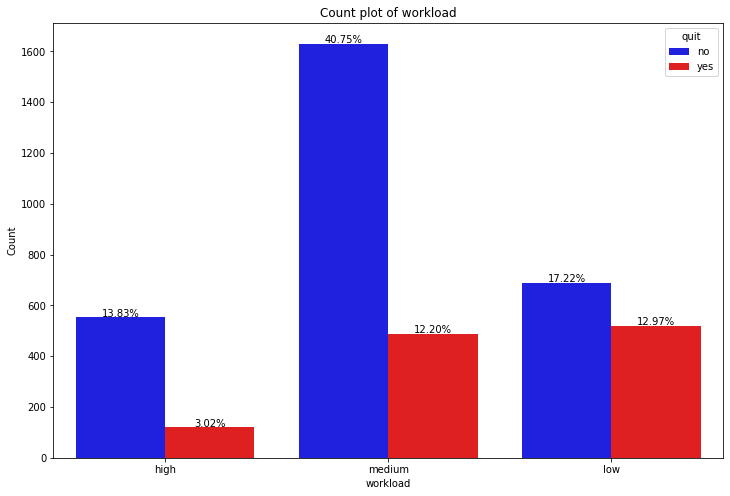

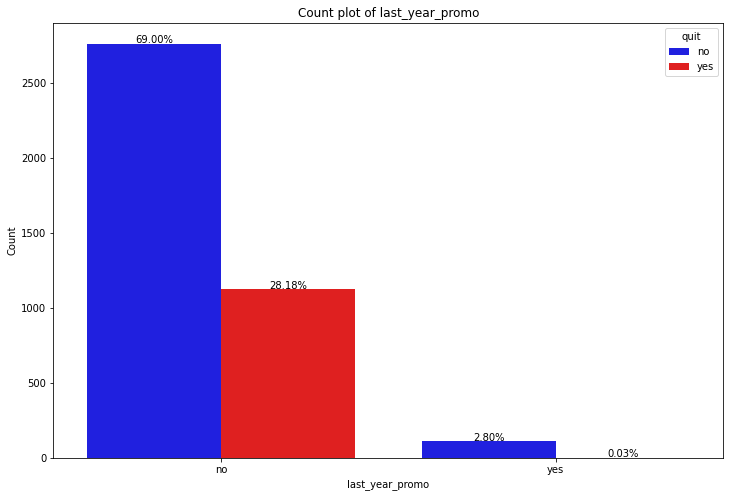

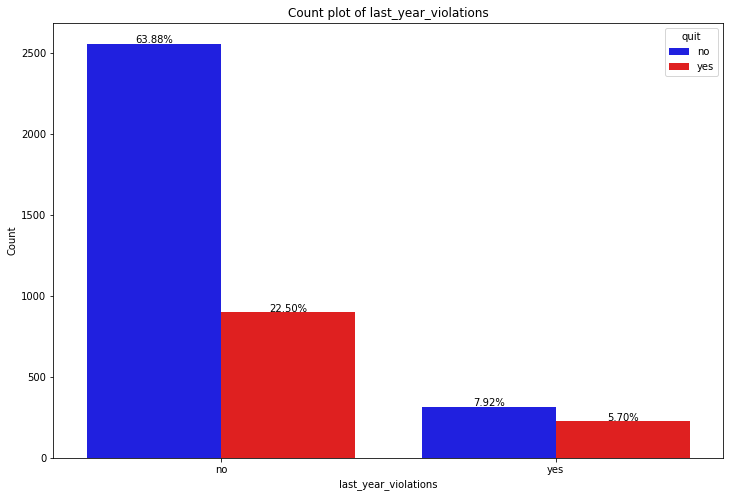

In [57]:
categorical_features = [col for col in train_quit.select_dtypes(include='object').columns if col != 'quit']

for col in categorical_features:
    plt.figure(figsize=(12, 8))
    
    ax = sns.countplot(x=col, data=train_quit, hue='quit', palette=['blue', 'red'])
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    total = len(train_quit[col])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total * 100:.2f}%', ha='center')
    
    plt.show()

Вывод по категориальным признакам:
    - Исходя из графиков, невозможно сделать однозначный вывод о том, есть ли связь между отделом и увольнениями. В среднем, каждый 3 сотрудник отдела увольняется. 4 отдела держат уровень увольнений в районе 40%, и лишь у HR он немного меньше, в районе 33%;
    - По уровню должностей всё гораздо прозрачнее, самые частые сотрудники которые уходят - джуны, их уходит больше чем остается, очень большая текучка; мидлы и синьоры практически не увольняются;
    - Исходя из графика по загрузке, видно, что увольняются люди в основном с низкой загрузкой;
    - несмотря на огромный дисбаланс в признаке "получал ли повышение" - можно всё равно заметить, что люди получившие повышение практически не увольняются, а вот те кто не получил, держат уже ставший привычным уровень в 40%;
    - Также несмотря на дисбаланс классов можно увидеть, что люди получившие предупреждение увольняются в процентном соотношении чаще чем те кто не получил.

#### Общий вывод по портрету:

Чаще всего увольняются сотрудники-джуны со стажем до 3 лет, с низким уровнем загруженности и такой же зарплатой, которая, вероятно, отчасти зависит от оценки руководителя. При этом процент увольнений во всех отделах примерно одинаковый, исключение HR - там немного ниже процент.


#### Влияние удовлетворенности работой на вероятность увольнения:

Для того чтобы выявить наличие корреляции между двумя параметрами для начала нужно объединить датафреймы и построить матрицу корреляций.

In [58]:
df=y_test.merge(y_test2, on='id')

In [59]:
df=df.set_index('id')

In [60]:
satis_rate = ['job_satisfaction_rate']
matrix = phik_matrix(df,interval_cols=interval_cols)

In [61]:
df.head()

,job_satisfaction_rate,quit
id,,
130604,0.74,no
825977,0.75,no
418490,0.60,yes
555320,0.72,no
826430,0.08,yes


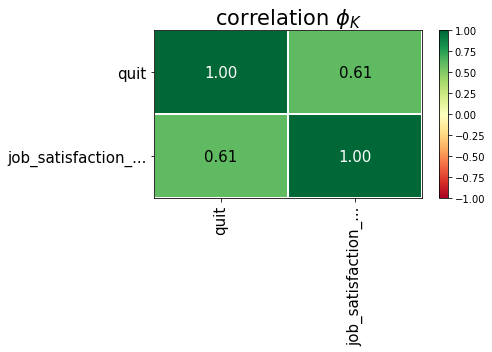

In [62]:
plot_correlation_matrix(
    matrix.values,
    x_labels=matrix.columns,
    y_labels=matrix.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(7, 5)
)

Исходя из матрицы, есть наличие средней по силе зависимости между двумя этими признаками. Построим гистограмму:

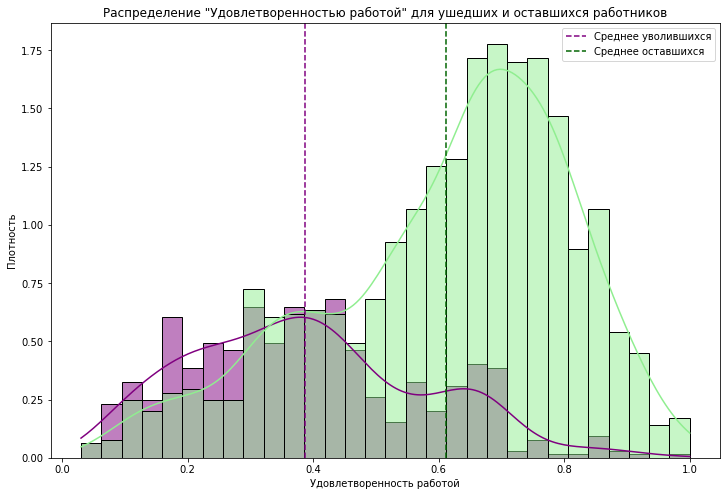

In [63]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='job_satisfaction_rate', hue='quit', bins=30, kde=True, stat='density', palette=['lightgreen', 'purple'])
plt.title('Распределение "Удовлетворенностью работой" для ушедших и оставшихся работников')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Плотность')
plt.legend(title='Уволился', labels=['no', 'yes'])

# Добавление вертикальных линий для среднего значения
mean_quit = df[df['quit'] == 'yes']['job_satisfaction_rate'].mean()
mean_stay = df[df['quit'] == 'no']['job_satisfaction_rate'].mean()
plt.axvline(mean_quit, color='purple', linestyle='--', label='Среднее уволившихся')
plt.axvline(mean_stay, color='darkgreen', linestyle='--', label='Среднее оставшихся')

plt.legend()
plt.show()

График подтверждает, что те кто доволен работой увольняются реже. Проведем статистический анализ данного предположения.
Для этого определим нулевую гипотезу: средние значения удовлетворенности работой для уволившихся и оставшихся работников равны. Альтернативная гипотеза - между двумя этими группами есть статистически значимые различия. Уровень значимости определим как 0,05. Используем t-тест Стьюдента

In [64]:

left = df[df['quit'] == 'yes']['job_satisfaction_rate']
stay = df[df['quit'] == 'no']['job_satisfaction_rate']


statistic, p_value = ttest_ind(left, stay)

print(f"Значение t-статистики: {statistic}")
print(f"P-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не отвергаем нулевую гипотезу.")

Значение t-статистики: -23.074784903634537
P-значение: 1.231122066517193e-104
Отвергаем нулевую гипотезу.


Вывод по влиянию уровня удовлетворенностью работой на веротяность увольнения:
  - Согласно проведенному ИАД, корреляционному и статистическому анализу можно утверждать, что степень удовлетворенности работой существенно снижает вероятность увольнения сотрудника, что в принципе, соответсвует здравому смыслу.

### Добавление нового признака

In [65]:
train_quit['job_satisfaction_rate_pred'] = randomized.best_estimator_.predict(train_quit.drop(['quit'], axis=1))
X_test2['job_satisfaction_rate_pred'] = randomized.best_estimator_.predict(X_test)

In [66]:
X_test2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824127


Вроде бы добавление прошло успешно. Можно переходить к подготовке данных.

### Подготовка данных и создание пайплайна

#### Подготовка данных

Подготовку данных будем производить схожим с первой задаче образом. Добавим лишь что целевой признак будем кодировать также как и бинарные признаки через OHE. Предсказанный уровень удовлетворенности можно не масштабировать, он и так лежит в промежутке 0 и 1, но оставим также как мы делали в первой задаче..


In [67]:
train_quit_3 = train_quit.drop(['id'], axis = 1)
X_train_quit_model = train_quit_3.drop(['quit'], axis=1)
y_train_quit_model = train_quit_3['quit']
X_train_quit_model.shape

(4000, 9)

In [68]:
X_test_merged = X_test2.merge(y_test2, on='id')
X_test_model = X_test_merged.drop(['id','quit'], axis = 1)
y_test_model = X_test_merged['quit']
X_test_model.head()
X_test_model.shape



(2000, 9)

In [69]:
X_test_model.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,marketing,junior,medium,2,no,no,5,28800,0.872000
1,hr,junior,medium,1,no,no,4,30000,0.668621
2,sales,middle,low,5,no,no,4,19200,0.657143
3,sales,middle,low,6,no,no,4,19200,0.655000
4,hr,middle,medium,5,no,no,5,40800,0.824127


In [70]:
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 
ohe_columns = ['last_year_violations', 'last_year_promo','dept']
ord_columns = ['level','workload']

#### Создание пайплайна

In [71]:
ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='error')
            )
        ]
    ) 

In [72]:
ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )  

In [73]:
data_preprocessor = ColumnTransformer([
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)], 
        remainder='passthrough')

In [74]:
pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

### Обучение модели

#### Поиск лучшей модели

In [75]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear',  'rbf', 'poly', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

По заданию, мы должны использовать метрику ROC-AUC- площадь под кривой. Скорее всего, выбор обусловлен тем, что данная метрика оценивает качество моделей в наиболее общем виде, учитывая все пороговые значения. Также она подходит потому, что у нас есть  дисбаланс классов в целевом признаке (исходя из данных полученных в ИАД).

In [76]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit_model, y_train_quit_model)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Sim...
                                                                       solver='liblinear')],
                                         'models__C': [0.1, 1.0, 10.0, 100.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [77]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent...
                                 

In [78]:
y_test_pred = randomized_search.predict_proba(X_test_model)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_model, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9281667950769474


Подойдя к концу проекта, и получив здесь ошибку "Found unknown categories [' '] in column 2 during transform", только сейчас и здесь я заметил, что в некоторых столбцах, есть не только nan, но и ' '. Возвращаюсь к предобработке и везде меняю ' ' на nan.

В результате модель SVC - опорные вектора,  полученная через randomized_search соответствует требованиям, указанным в задании (метрика ROC-AUC > 0,91). Проведем анализ важности признаков.

In [79]:
X_train_quit_model['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [80]:
X_test_model['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

#### Анализ важности признаков

In [81]:
preprocessor = randomized_search.best_estimator_['preprocessor']
all_names = preprocessor.get_feature_names_out().tolist()
all_names 

['ohe__last_year_violations_yes',
 'ohe__last_year_promo_yes',
 'ohe__dept_marketing',
 'ohe__dept_purchasing',
 'ohe__dept_sales',
 'ohe__dept_technology',
 'ord__level',
 'ord__workload',
 'num__salary',
 'num__employment_years',
 'num__supervisor_evaluation',
 'num__job_satisfaction_rate_pred']

  0%|          | 0/100 [00:00<?, ?it/s]

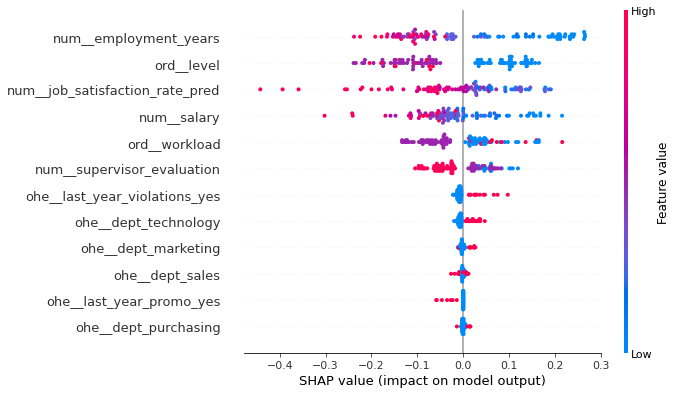

In [82]:
preprocessor = randomized_search.best_estimator_['preprocessor']
X_train_encoded = preprocessor.fit_transform(X_train_quit_model.sample(100, axis=0))
model = randomized_search.best_estimator_.named_steps['models']
X_train_encoded.shape, model

X_shap = shap.kmeans(X_train_encoded, 19)
explainer = shap.KernelExplainer(model.predict_proba, X_shap,feature_names=all_names)

x_test_shap = preprocessor.transform(X_test_model.sample(100, axis=0))
shap_values = explainer(x_test_shap)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=None)

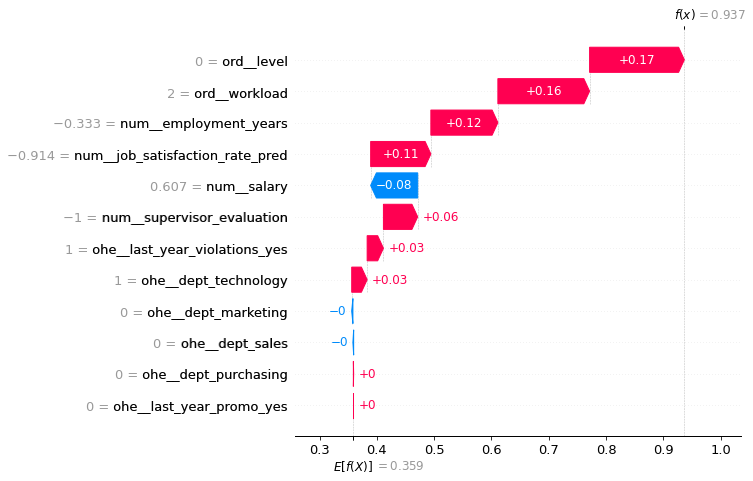

In [83]:
num_features = len(shap_values[0, :, 1])
shap.plots.waterfall(shap_values[0, :, 1], max_display=num_features)

  0%|          | 0/50 [00:00<?, ?it/s]

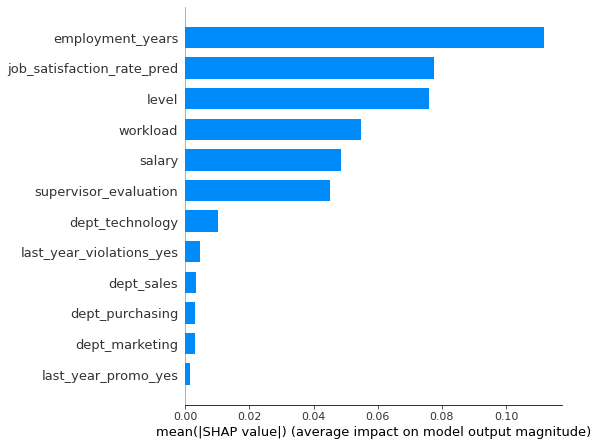

In [84]:
COUNT = 50
 
best_model = randomized_search.best_estimator_.named_steps['models']

preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train_quit_model)
X_test_preprocessed = preprocessor.transform(X_test_model)

ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = ord_columns
num_feature_names = num_columns


all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

shap.summary_plot(shap_values[:, :, 1], X_test_preprocessed_smpl, plot_type='bar' )

Вывод по анализу важности признаков:
    Больше всего на модель влияют следующие параметры: уровень удовлетворённости работой, стаж работы и уровень занимаемой должности. Следом за этой тройкой идут нагрузка, зарплата и оценка руководителя. Остальные признаки имеют очень слабое влияние.

## Общий вывод по проекту

Данный проект включал в себя решение двух задач.

1 задача состояла в том чтобы построить модель предсказания уровня удовлетворенности работой.
2 задача состояла в том, чтобы построить модель предсказания увольнения сотрудников.

Обе задачи включали общие этапы:
    Загрузка и импорт библиотек;
    Загрузка данных и их первичный осмотр;
    Предобработка данных (в обеих задачах она была практически символической);
    Исследовательский анализ данных, здесь мы выяснили как распределены значения количественных и категориальных признаков, при чем в обеих задачах их распределения схожи.;
    Кореляционный анализ.
    
Далее начались небольшие расхождения в этапах. Исследовательский анализ данных во второй задачи был более обширным и предполагал составление портрета типичного увольняющегося отрудника. По результатам исследования им стал джун с небольшой зарплатой и загрузкой, проработавший менее 3 лет и не имеющий хороших отзывов от руководящего состава. Также на данном этапе мы установили, что есть взаимосвязь между увольнениями и уровнем удовлетворенности работой. Данная гипотеза была проверена статистически, с использованием критерия Стюдента.

1 задача предполагала построение пайплайна и нахождения лучшей модели из двух с несколькими гиперпараметрами для предсказания уровня удовлетворенности работой. По результатам проделанных исследований была получена модель DecisionThreeRegressor с максимальной глубиной равной 13 и количеством признаков равным 8. Метрика SMAPE на тестовой выборке составила 14,65 - что удовлетворяет условиям задачи. по результатам анализа важности признаков выявлено, что у модели есть признак, на который она ориентируется в первую очередь - это оценка руководителя. Далее следует с большим отставанием стаж работы. Затем идут практически с одинаковым влиянием на предсказание - зарплата, должность и наличие нарушений договора. На остальные признаки модель практически не смотрит.

2 Задача предполагала построение пайплайна с целью нахождения лучшей модели для задачи классификации предсказания признака уволиться/останется. По результатам проведенных исследований полученная модель это SVC - метод опорных векторов. Значение метрики точности модели ROC-AUC составили ~0,925, что соответствует поставленной задаче. Больше всего на модель влияют следующие параметры: стаж работы, уровень удовлетворённости и уровень занимаемой должности. Следом за этой тройкой идут нагрузка, оценка руководителя и зарплата. Остальные признаки имеют очень слабое влияние.

Рекомендации заказчику:
Для сокращения уровня текучки кадров заказчику требуется проводить следующие действия:
    - Не тянуть с повышениями зарплаты и должности - особенно джунов (группа с наибольшим количеством увольнений), всего 3% повышаемых в год - как-то слишком мало;
    - Следить за загрузкой персонала, человек приходит на работу набираться опыта и совершенствоваться, просто просиживать штаны нравится далеко не всем;
    - Обращать внимание на оценки руководства, иногда занудные замечания по нарушениям могут портить настроение сотруднику, также считается, что похвала стимулирует рабочий процесс лучше, чем постоянное акцентирование внимания на недочетах в работе.